In [1]:
%load_ext autoreload
%autoreload 2

# 🍕An Introduction to Slice Discovery with Domino

This is the companion notebook to our blog post "[An Introduction to Slice Discovery with Domino](https://sabrieyuboglu.notion.site/Domino-Blog-Post-338c2e8f07bb4e2b999c4c4b6be01182)". We recommend reading the blogpost first, only referring to this notebook if you're looking to replicate the experiments we describe in the post. The sections of this notebook mirror the sections of the blogpost.

For more details, see our paper "[Domino: Discovering Systematic Errors with Cross-modal Embeddings](https://arxiv.org/pdf/2203.14960.pdf)".


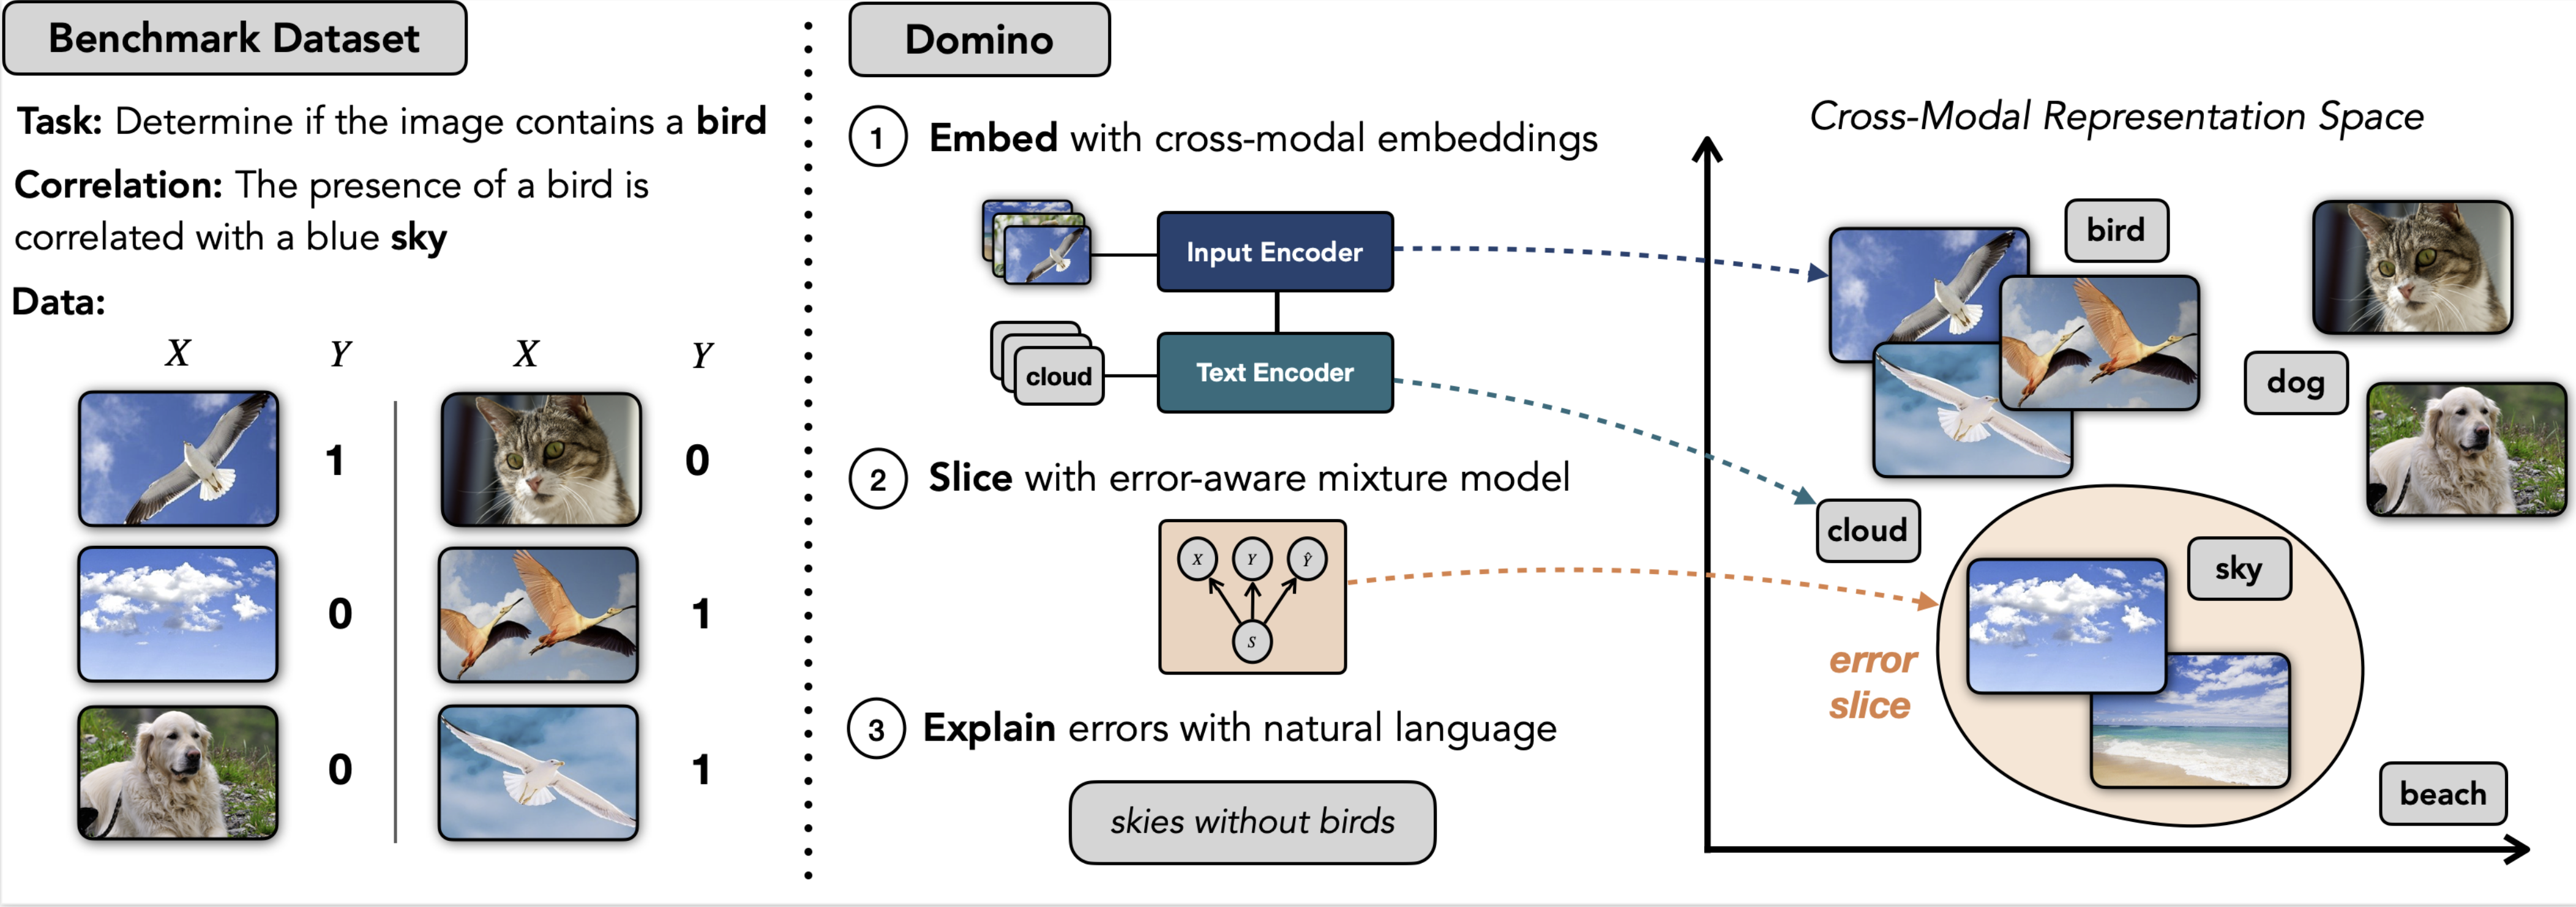




## Evaluating a model with the standard toolbox

Let’s investigate a model that you’ve likely used before: a [ResNet18 pretrained on ImageNet](https://pytorch.org/vision/stable/models.html).

Suppose we’d like to use this pretrained ResNet to scrape images of **cars** from the internet. Before doing so, it would be prudent to measure how good the model actually is at distinguishing cars from other objects...

Continue following along in the blogpost.

In [ ]:
# if you don't have access to a GPU, set this to `DEVICE="cpu"`

DEVICE = 0

### 💻 Loading the model and dataset

In [2]:
from domino import explore, DominoSlicer
import meerkat as mk

In [3]:
dp = mk.datasets.get(
    "imagenet", 
    dataset_dir="/home/common/datasets/imagenet",
    download=False
)
dp = dp.lz[dp["split"] == "valid"]

In [4]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)

### 💻 Running inference 

In [5]:
# source: https://github.com/pytorch/vision/issues/39
import torchvision.transforms as transforms
import torch 


transform = transforms.Compose(
    [
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

dp["input"] = dp["image"].to_lambda(transform)
model.to(DEVICE)
@torch.autograd.no_grad()
def forward(batch):
    return model(batch.data.to(DEVICE)).cpu().numpy()

dp["preds"] = dp["input"].map(forward, is_batched_fn=True, batch_size=128, pbar=True)

/home/common/envs/conda/envs/domino-release/lib/python3.8/site-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


  0%|          | 0/391 [00:00<?, ?it/s]

### 💻 Computing metrics 

In [6]:
# There isn't actually a general "car" class in ImageNet.
# There are only more specific subclasses like "sports car", 
# "jeep", "convertible". Luckily, because imagenet labels 
# are organized into an ontology, we can rather easily get 
# labels for a general "car" class. 

import nltk
import numpy as np
import pandas as pd
import torch
import warnings 

from nltk.corpus import wordnet as wn
try:
    nltk.data.find("corpora/wordnet")
except LookupError:
    nltk.download("wordnet")

def get_hypernyms(data_dp: mk.DataPanel):
    synsets = set(data_dp["synset"].unique())
    hypernyms = []

    for synset in synsets:
        synset = wn.synset(synset)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            for hypernym in synset.closure(lambda s: s.hypernyms()):
                hypernyms.append(
                    {
                        "synset": synset.name(),
                        "hypernym": hypernym.name(),
                    }
                )

    # run through the hypernyms to get their hypernyms
    df = pd.DataFrame(hypernyms)
    for hypernym in df["hypernym"].unique():
        synset = wn.synset(hypernym)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            for hypernym in synset.closure(lambda s: s.hypernyms()):
                hypernyms.append(
                    {
                        "synset": synset.name(),
                        "hypernym": hypernym.name(),
                    }
                )
    return pd.DataFrame(hypernyms)

def get_target_labels(dp: mk.DataPanel, target_synset: str = "car.n.01"):
    dp = dp.view()
    pos_offset_to_synset = {
        pos_offset: wn.synset_from_pos_and_offset(
            pos=pos_offset[0], offset=int(pos_offset[1:])
        ).name()
        for pos_offset in dp["synset"].unique()
    }

    dp["synset_pos_offset"] = dp["synset"]
    dp["synset"] = dp["synset"].apply(lambda x: pos_offset_to_synset[x])
    
    hypernym_dp = get_hypernyms(dp)
    
    target_synsets = set(
        hypernym_dp[hypernym_dp["hypernym"] == target_synset]["synset"]
    )
    return dp["synset"].isin(target_synsets)

In [7]:
dp["target"] = get_target_labels(dp, target_synset="car.n.01")
dp["prob"]  = torch.softmax(torch.tensor(dp["preds"].data), dim=-1).data[:, np.unique(dp.lz[dp["target"]]["class_idx"])].sum(axis=1)

In [9]:
from sklearn.metrics import roc_auc_score

roc_auc_score(
    dp["target"], 
    dp["prob"]
)

0.997653292929293

### 💻 Plotting precision-recall curve

In [10]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, precision_recall_curve
precision, recall, thresholds = precision_recall_curve(
    dp["target"], 
    dp["prob"]
)

/home/common/envs/conda/envs/domino-release/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'precision')

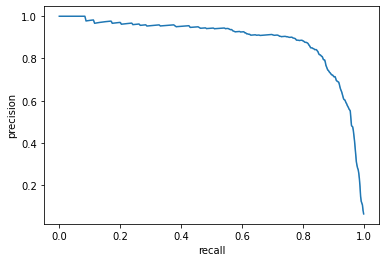

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.lineplot(recall, precision)
plt.xlabel("recall")
plt.ylabel("precision") 

### 💻 Displaying errors

,image_id (PandasSeriesColumn),image (ImageColumn),target (PandasSeriesColumn),prob (TensorColumn)
0,ILSVRC2012_val_00040366,,False,tensor(0.8296)
1,ILSVRC2012_val_00011630,,True,tensor(0.0414)
2,ILSVRC2012_val_00029201,,False,tensor(0.9523)
3,ILSVRC2012_val_00012199,,False,tensor(0.6321)
4,ILSVRC2012_val_00040345,,False,tensor(0.5051)
...,...,...,...,...
150,ILSVRC2012_val_00033224,,False,tensor(0.5446)
151,ILSVRC2012_val_00012763,,False,tensor(0.7184)
152,ILSVRC2012_val_00003886,,True,tensor(0.2036)
153,ILSVRC2012_val_00043105,,False,tensor(0.8816)

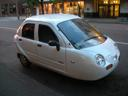
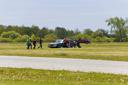
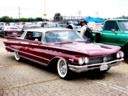
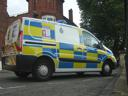
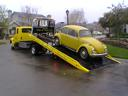
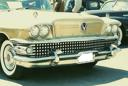
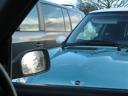
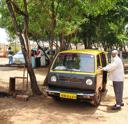
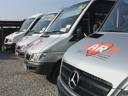
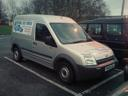

In [13]:
dp.lz[
    (dp["target"].data != (dp["prob"] > 0.5)).astype(bool)
][['image_id', "image", "target", "prob"]]

## Evaluating a model with slice discovery

This brings us to slice discovery: the task of mining unstructured input data for semantically meaningful subgroups on which a model performs poorly. We refer to automated techniques that mine input data for semantically meaningful slices as slice discovery methods (SDMs)...

### 💻 Embedding images

In [14]:
from domino import embed
dp = embed(
    data=dp, input_col="image", encoder="clip", device=0
)

  0%|          | 0/391 [00:00<?, ?it/s]

### 💻 Running Domino mixture model

In [15]:
domino = DominoSlicer(
    y_log_likelihood_weight=40,
    y_hat_log_likelihood_weight=40,
    n_mixture_components=60,
    n_slices=10,
    max_iter=10,
    n_pca_components=128,
    init_params="confusion",
    confusion_noise=3e-3
)

domino.fit(data=dp, embeddings="clip(image)", targets="target", pred_probs="prob")
dp["domino_slices"] = domino.predict_proba(
    data=dp, embeddings="clip(image)", targets="target", pred_probs="prob"
)

  0%|          | 0/10 [00:00<?, ?it/s]

/pd/sabri/code/domino/domino/_slice/domino.py:547: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


### 💻 Embedding candidate descriptions

In [16]:
from domino import generate_candidate_descriptions

phrase_templates = [
    "a photo of [MASK].",
    "a photo of {} [MASK].",
    "a photo of [MASK] {}.",
    "a photo of [MASK] {} [MASK].",
]

text_dp = generate_candidate_descriptions(
    templates=phrase_templates
)

text_dp = embed(
    text_dp, 
    input_col="output_phrase", 
    encoder="clip",
    device=0
)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

### 💻 Describing slices 

In [17]:
explore(
    data=dp,
    embeddings="clip(image)",
    pred_probs="prob",
    targets="target",
    slices="domino_slices",
    text=text_dp,
    text_embeddings="clip(output_phrase)",
)

FloatSlider(value=0.5, continuous_update=False, description='Slice Inclusion Threshold', max=1.0, readout_form…

Output()

## Evaluating slice discovery methods

SDMs like Domino have traditionally been evaluated qualitatively, due to a lack of a simple quantitative approach. Typically, in these evaluations, the SDM is applied to a few different models and identified slices are visualized, just as we did above.  Practitioners can then inspect the slices and judge whether the slices make sense. However, these qualitative evaluations are subjective and do not scale beyond more than a few models. Moreover, they cannot tell us if the SDM has missed an important, coherent slice...

### 💻 Loading the CelebA dataset

,image (ImageColumn),file (PandasSeriesColumn),identity (PandasSeriesColumn),5_o_clock_shadow (PandasSeriesColumn),arched_eyebrows (PandasSeriesColumn),attractive (PandasSeriesColumn),bags_under_eyes (PandasSeriesColumn),bald (PandasSeriesColumn),bangs (PandasSeriesColumn),big_lips (PandasSeriesColumn),big_nose (PandasSeriesColumn),black_hair (PandasSeriesColumn),blond_hair (PandasSeriesColumn),blurry (PandasSeriesColumn),brown_hair (PandasSeriesColumn),bushy_eyebrows (PandasSeriesColumn),chubby (PandasSeriesColumn),double_chin (PandasSeriesColumn),eyeglasses (PandasSeriesColumn),goatee (PandasSeriesColumn),gray_hair (PandasSeriesColumn),heavy_makeup (PandasSeriesColumn),high_cheekbones (PandasSeriesColumn),male (PandasSeriesColumn),mouth_slightly_open (PandasSeriesColumn),mustache (PandasSeriesColumn),narrow_eyes (PandasSeriesColumn),no_beard (PandasSeriesColumn),oval_face (PandasSeriesColumn),pale_skin (PandasSeriesColumn),pointy_nose (PandasSeriesColumn),receding_hairline (PandasSeriesColumn),rosy_cheeks (PandasSeriesColumn),sideburns (PandasSeriesColumn),smiling (PandasSeriesColumn),straight_hair (PandasSeriesColumn),wavy_hair (PandasSeriesColumn),wearing_earrings (PandasSeriesColumn),wearing_hat (PandasSeriesColumn),wearing_lipstick (PandasSeriesColumn),wearing_necklace (PandasSeriesColumn),wearing_necktie (PandasSeriesColumn),young (PandasSeriesColumn),img_path (PandasSeriesColumn),image_id (PandasSeriesColumn),split (PandasSeriesColumn)
0,,000001.jpg,2880,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,img_align_celeba/000001.jpg,000001.jpg,train
1,,000002.jpg,2937,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,img_align_celeba/000002.jpg,000002.jpg,train
2,,000003.jpg,8692,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,img_align_celeba/000003.jpg,000003.jpg,train
3,,000004.jpg,5805,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,img_align_celeba/000004.jpg,000004.jpg,train
4,,000005.jpg,9295,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,img_align_celeba/000005.jpg,000005.jpg,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,,000016.jpg,4905,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,img_align_celeba/000016.jpg,000016.jpg,train
16,,000017.jpg,667,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,img_align_celeba/000017.jpg,000017.jpg,train
17,,000018.jpg,2464,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,1,0,1,1,0,0,img_align_celeba/000018.jpg,000018.jpg,train
18,,000019.jpg,2929,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,1,0,1,img_align_celeba/000019.jpg,000019.jpg,train

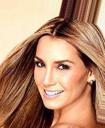
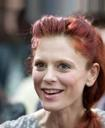
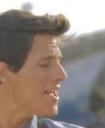
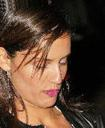
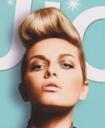
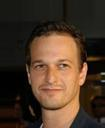
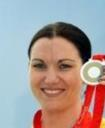
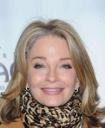
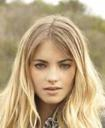
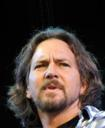

In [18]:
dp = mk.datasets.get(
    "celeba", 
    # Note: you should change this directory to point to a local download of
    # CelebA
    dataset_dir="/home/common/datasets/celeba",
)

dp.data.reorder(["image"] + dp.columns[:-1])

dp.head(20)


### 💻 Inducing a spurious correlation

,image (ImageColumn),eyeglasses (PandasSeriesColumn),wearing_necktie (PandasSeriesColumn)
0,,0,0
1,,0,0
2,,1,1
3,,0,0
4,,0,0
...,...,...,...
15,,0,0
16,,0,0
17,,0,0
18,,0,0

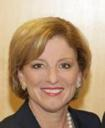
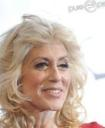
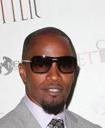
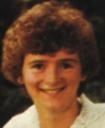
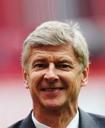
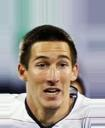
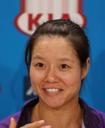
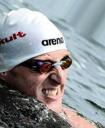
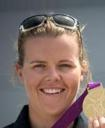
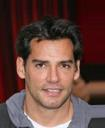

In [19]:
from domino.eval.utils import induce_correlation

idxs = induce_correlation(
    dp=dp,
    corr=0.8,
    n=30_000,
    attr_a="eyeglasses",
    attr_b="wearing_necktie"
)
corr_dp = dp.lz[idxs]

corr_dp[["image", "eyeglasses", "wearing_necktie"]].head(20)

### 💻 Training a model

In [20]:
from domino.eval.train import train

corr_dp["split"] = pd.Series(np.random.choice(["train", "valid"], len(corr_dp), p=[0.6, 0.4]))

model = train(
    dp=corr_dp,
    input_column="image",
    target_column="wearing_necktie",
    id_column="file",
    batch_size=128,
    max_epochs=1
)

[2022-04-02 21:54:14,530][INFO][pytorch_lightning.utilities.seed:69] :: Global seed set to 123
/home/common/envs/conda/envs/domino-release/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
[2022-04-02 21:54:14,762][INFO][pytorch_lightning.utilities.distributed:1570] :: GPU available: True, used: True
[2022-04-02 21:54:14,763][INFO][pytorch_lightning.utilities.distributed:1573] :: TPU available: False, using: 0 TPU cores
[2022-04-02 21:54:14,764][INFO][pytorch_lightning.utilities.distributed:1576] :: IPU available: False, using: 0 IPUs
[2022-04-02 21:54:14,787][INFO][pytorch_lightning.accelerators.gpu:59] :: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[2022-04-02 21:54:14,847][INFO][pytorch_lightning.callbacks.model_summary:73] :: 
  | Name    | Type       | Params
---------------------------------------
0 

Validation sanity check: 0it [00:00, ?it/s]

/home/common/envs/conda/envs/domino-release/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:453: UserWarning: Your `val_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/home/common/envs/conda/envs/domino-release/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
[2022-04-02 21:54:17,158][INFO][pytorch_lightning.utilities.seed:69] :: Global seed set to 123


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/common/envs/conda/envs/domino-release/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 17. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


### 💻 Checking model performance on slice

In [21]:
corr_dp["input"] = corr_dp["image"].to_lambda(model.config["transform"])
model.to(DEVICE)
@torch.autograd.no_grad()
def forward(batch):
    return torch.softmax(model(batch.data.to(DEVICE)), dim=1).cpu().numpy()

corr_dp["probs"] = corr_dp["input"].map(
    forward, 
    is_batched_fn=True, 
    batch_size=128, 
    pbar=True,
    num_workers=6
)

valid_dp = corr_dp.lz[corr_dp["split"] == "valid"]

pos_dp = valid_dp.lz[valid_dp["wearing_necktie"] != 1]
print(f'Overall Specificity:{(pos_dp["probs"][:, 0] > 0.5).mean()}')
print(f'In-slice Specificity:{(pos_dp.lz[pos_dp["eyeglasses"] == 1]["probs"][:, 1] > 0.5).mean()}')

  0%|          | 0/235 [00:00<?, ?it/s]

Overall Specificity:0.9884078971200869
In-slice Specificity:0.3939393939393939


### 💻 Running the SDM

In [23]:
from domino import DominoSlicer

phrase_templates = [
    "a photo of a person {} [MASK].",
    "a photo of a person [MASK] {}.",
    "a photo of a person [MASK] {} [MASK].",
    "a photo of a person [MASK] [MASK] {}.",
    "a photo of [MASK] {} person",
    "[MASK] {} photo of a person",
]

from domino import embed, generate_candidate_descriptions


text_dp = generate_candidate_descriptions(
    templates=phrase_templates
)

text_dp =embed(
    text_dp, 
    input_col="output_phrase", 
    encoder="clip",
    device=0
)

valid_dp = corr_dp.lz[corr_dp["split"] == "valid"]
valid_dp = embed(data=valid_dp, input_col="image", encoder="clip", device=0)

domino = DominoSlicer(
    y_log_likelihood_weight=20,
    y_hat_log_likelihood_weight=20,
    n_mixture_components=30,
    n_slices=10,
    max_iter=10,
    n_pca_components=128,
    init_params="confusion",
    confusion_noise=3e-3
)

domino.fit(data=valid_dp, embeddings="emb", targets="target", pred_probs="probs")
valid_dp["domino_slices"] = domino.transform(
    data=valid_dp, embeddings="emb", targets="target", pred_probs="probs"
)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

KeyError: 'Column `emb` does not exist.'

### 💻 Computing precision-at-10

In [ ]:
slice_dp = valid_dp.lz[(-valid_dp["domino_slices"].data[:, 5]).argsort()]
slice_dp["target_slice"] = ~slice_dp["wearing_necktie"] & slice_dp["eyeglasses"]
slice_dp.lz[:10]["target_slice"].mean()